# Simple Graph Embedding (for Ron DP) 

https://karateclub.readthedocs.io/en/latest/notes/introduction.html#graph-embedding

first pip install karate club if you don't have it

In [1]:
import networkx as nx
import pandas as pd

Takes a list of nx.graph, each of out conversations is one graph. 

loading data

In [16]:
import tqdm
df = pd.read_csv('./cmv-random-branches-recsys.tsv', sep='\t',
                   # names=['conversation_id', 'message_id', 'parent_id', "text", "processed", "user_id"],
                   dtype = {'parent_id': 'str', 'message_id':'str' })
                   
df.head()

,conv_id,message_id,parent_id,content,cleaned_content,user_id
0,0,7f30fw,None,Reddit is the modern-day shoeshine boy: the la...,reddit is the modern-day shoeshine boy : the l...,17090
1,0,dq96y51,7f30fw,Can you define “real gains”? People have been ...,can you define “ real gains ” ? people have be...,24410
2,0,dq9acxt,dq96y51,"As opposed to speculative profits. As in, the ...","as opposed to speculative profits . as in , th...",17090
3,0,dq9az1f,dq9acxt,So what about the examples I gave? Would they ...,so what about the examples i gave ? would they...,24410
4,0,dq9kk1z,dq9az1f,What they're trying to say I think is that tho...,what they're trying to say i think is that tho...,38507


Pre-processing, we want just the reply-to relation between posts. 

In [17]:
# trec = trec.drop('posting_time', axis=1)
df = df.dropna()
df.head()

,conv_id,message_id,parent_id,content,cleaned_content,user_id
0,0,7f30fw,None,Reddit is the modern-day shoeshine boy: the la...,reddit is the modern-day shoeshine boy : the l...,17090
1,0,dq96y51,7f30fw,Can you define “real gains”? People have been ...,can you define “ real gains ” ? people have be...,24410
2,0,dq9acxt,dq96y51,"As opposed to speculative profits. As in, the ...","as opposed to speculative profits . as in , th...",17090
3,0,dq9az1f,dq9acxt,So what about the examples I gave? Would they ...,so what about the examples i gave ? would they...,24410
4,0,dq9kk1z,dq9az1f,What they're trying to say I think is that tho...,what they're trying to say i think is that tho...,38507


Process dataframe to nx graphs

In [18]:
graphs = []
grouped = df.groupby('conv_id')
for name, conversation_ in tqdm.tqdm(grouped):
    conversation = conversation_.filter(['message_id', 'parent_id'])
    d = {k: i for i, k in enumerate(set(conversation[["message_id", "parent_id"]].values.ravel()))}
    conversation["node_index"] = [d[n] for n in conversation["message_id"]]
    conversation["parent_index"] = [d[n] for n in conversation["parent_id"]]
    edges = conversation[["node_index", "parent_index"]].itertuples(index=False, name=None)
    G = nx.from_edgelist(edges)
    graphs.append(G)

100%|██████████| 5583/5583 [03:09<00:00, 29.40it/s]


In [19]:
len(graphs), graphs[700].number_of_edges()

(5583, 4)

We can plot the one of the graphs to feel better with ourselfs

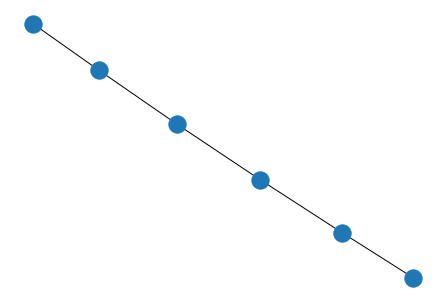

In [20]:
import random
random_conversation = random.choice(graphs)
nx.draw(random_conversation)

## Embedding

First type of embedding, called Feather,

In [ ]:
# from karateclub.dataset import GraphSetReader

# reader = GraphSetReader("reddit10k")

# graphs = reader.get_graphs()

In [21]:
for i, g in enumerate(graphs):
    assert(list(range(len(g.nodes))) == sorted(g.nodes))

In [22]:
print(len(graphs))
connected_graphs = list(filter(nx.is_connected, graphs))
print(len(connected_graphs))


5583
5583


In [23]:
from karateclub import FeatherGraph

model = FeatherGraph()
model.fit(graphs)
X = model.get_embedding()

In [24]:
X

array([[0.99994571, 0.99298369, 0.97443243, ..., 0.        , 0.        ,
        0.        ],
       [0.99994571, 0.99298369, 0.97443243, ..., 0.        , 0.        ,
        0.        ],
       [0.99994484, 0.99287198, 0.97402601, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.99994192, 0.99249498, 0.97265432, ..., 0.        , 0.        ,
        0.        ],
       [0.99994873, 0.99337465, 0.97585492, ..., 0.        , 0.        ,
        0.        ],
       [0.99994484, 0.99287198, 0.97402601, ..., 0.        , 0.        ,
        0.        ]])

Probebly a better representation

In [25]:
from karateclub import Graph2Vec
model = Graph2Vec(dimensions=10)
model.fit(graphs)
X = model.get_embedding()

In [26]:
X

array([[-0.05689806, -0.08147454,  0.07162268, ..., -0.04527807,
         0.03273629, -0.00165327],
       [-0.02387063, -0.00881603, -0.00891049, ...,  0.01242553,
         0.05427465, -0.05777711],
       [-0.00456831, -0.04390918, -0.01685316, ...,  0.01146604,
         0.04305845,  0.01203374],
       ...,
       [ 0.02944114, -0.09442605,  0.00117423, ..., -0.00481945,
         0.05855107, -0.0732697 ],
       [-0.01344212, -0.00022963,  0.0059538 , ...,  0.00392911,
        -0.03048843, -0.0544934 ],
       [ 0.01390203, -0.03381307,  0.03384782, ..., -0.03362345,
        -0.02073043, -0.06135229]], dtype=float32)

In [27]:
# Create CSV output for Ron DP

In [ ]:
# connected_graphs_indices = [i for i in range(len(graphs)) if nx.is_connected(graphs[i])]

In [28]:
graphs_indices = list(range(len(graphs)))
out = pd.DataFrame(X).assign(conversation_id = graphs_indices).set_index('conversation_id')
out

,0,1,2,3,4,5,6,7,8,9
conversation_id,,,,,,,,,,
0,-0.056898,-0.081475,0.071623,0.016880,-0.015101,0.025365,-0.027020,-0.045278,0.032736,-0.001653
1,-0.023871,-0.008816,-0.008910,-0.025696,-0.023721,0.050015,0.008028,0.012426,0.054275,-0.057777
2,-0.004568,-0.043909,-0.016853,0.061091,0.015644,0.051629,0.047616,0.011466,0.043058,0.012034
3,-0.058055,-0.076366,0.084920,0.078710,-0.108443,0.064545,0.050668,-0.032235,-0.022451,-0.049635
4,-0.056303,-0.028320,0.082825,0.032530,-0.109185,0.048401,0.074119,-0.006580,-0.025981,-0.051455
...,...,...,...,...,...,...,...,...,...,...
5578,0.005759,-0.084160,0.012845,0.052387,-0.085612,0.104369,-0.019359,-0.048649,0.054962,-0.064777
5579,0.017677,-0.015531,0.012192,0.073049,-0.055130,0.088318,-0.018050,-0.010689,0.037976,-0.033315
5580,0.029441,-0.094426,0.001174,0.097216,-0.098449,0.104239,0.062946,-0.004819,0.058551,-0.073270


In [29]:
out.to_csv('cmv_embedding_10.csv', sep= ' ')

Enjoy!